## PSGD - KDD Cup98

In [ ]:
%%file PSGD_cup.py
from sklearn.datasets import load_svmlight_file
import os
import numpy as np
import pandas as pd
import scipy
import math
import matplotlib.pyplot as plt
from mpi4py import MPI

#Initialize communicators
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

#Reading Virusshare dataset
def read_virusshare(directory):
    data = np.array([])
    label = []
    a = 0
    for files in os.listdir(directory)[:1]:
        x,y = load_svmlight_file(directory+files)
        a+=x.shape[0]
        if x.shape[1] < 479:
            pad = np.zeros((x.shape[0],1))
            x = scipy.sparse.hstack((x,np.array(pad)))
        data = scipy.sparse.vstack((data,x))
        data = data.tocsr()
        label.extend(y)
    return data[1:,].tocsr(),label

#Reading KDD Cup 1998 dataset
def read_cup98(directory):
    data = pd.read_csv(directory,low_memory=False)
    return data

#To calculate RMSE
def RMSE(y_data,y_pred):
    return np.sqrt(np.sum(pow((y_data - y_pred),2)))/len(y_pred)

#To calculate loss
def loss(beta,data,Y_train):
    pred = linalg_prediction(beta,data)
    return np.sum(pow((Y_train - pred),2))

#To predict with learned model
def linalg_prediction(beta,data):
    X = np.ones((data.shape[0],data.shape[1]+1))
    X[:,1:] = data
    return np.dot(beta,X.T)

#Linear Regression with Stochastic Gradient Descent 
def linreg_PSGD(alpha,beta,Y_train,X_train):
    
    X = np.ones((X_train.shape[0],X_train.shape[1]+1))
    X[:,1:] = X_train
    index = np.arange(0,len(X))
    np.random.shuffle(index)
    for i in index:
        xtr = X[i]
        ytr = Y_train[i]
        Y_prediction = np.dot(beta,xtr.T)
        residual = Y_prediction - ytr
        func_gradient = 2 * np.dot(xtr.T,residual)
        beta = beta - (alpha * func_gradient)
    return beta  

#Splitting the data to Test and Train
def create_Test_Train_data(X_data,Y_data):
    Y_train = Y_data[:math.ceil(0.7*len(Y_data))]
    Y_test = Y_data[math.ceil(0.7*len(Y_data)):]
    X_train = X_data[:math.ceil(0.7*len(X_data))]
    X_test = X_data[math.ceil(0.7*len(X_data)):]
    return Y_train,Y_test,X_train,X_test

flag = True
beta_split,beta_new = None,None
epoch = 1
rmse_train,rmse_test,time = [],[],[]

#Master
if rank == 0:
    beta_new,beta_split = None,None
    cup_directory = "G:/DA - Hildeshim/DDA Lab/Exercise 4/cup98lrn/cup98LRN_crop.txt"
    cup_data = read_cup98(cup_directory)
    cols = cup_data.columns
    numCol = cup_data._get_numeric_data().columns
    catCol = list(set(cols) - set(numCol))
    for each in numCol:
        cup_data[each] = cup_data[each].astype('float')
    for each in catCol:
        cup_data[each] = cup_data[each].astype('category')
    cat_columns = cup_data.select_dtypes(['category']).columns
    cup_data[cat_columns] = cup_data[cat_columns].apply(lambda x: x.cat.codes)
    cup_data = cup_data.fillna(cup_data.mean())
    Y_data = list(cup_data["AVGGIFT"])
    X_data = cup_data.drop(columns = ['AVGGIFT'])
    Y_train,Y_test,X_train,X_test = create_Test_Train_data(X_data,Y_data)
    X_train_split = np.array_split(X_train,size-1)
    Y_train_split = np.array_split(Y_train,size-1)
    beta = np.zeros((X_data.shape[1]+1))
    for worker in range(1,size):
        comm.send(X_train_split[worker-1],dest = worker,tag = 1) #Sending the X_train and Y_train data
        comm.send(Y_train_split[worker-1],dest = worker,tag = 2)

else:
    beta = None
    X_test = None
    Y_test = None
    X_train = comm.recv(source = 0,tag = 1) #Receiving the X_train and Y_train data
    Y_train = comm.recv(source = 0,tag = 2)
    
start = MPI.Wtime()
for i in range(100): #epochs
    beta = comm.bcast(beta,root = 0)
    X_test = comm.bcast(X_test,root = 0)  #Broadcast X_test, Y_test and beta
    Y_test = comm.bcast(Y_test,root = 0)
    if rank != 0:
        beta_split = linreg_PSGD(0.5e-14,beta,Y_train,X_train)
    
    comm.Barrier()
    beta_new = comm.gather(beta_split,0)
    comm.Barrier()
    if rank == 0:

        losstrain_old = loss(beta,X_train,Y_train)
        beta = np.sum(np.array(beta_new)[1:,])/(size-1)
        losstrain_new= loss(beta,X_train,Y_train)
        if abs(losstrain_old - losstrain_new) < 1e-20: #Convergence
            print("Converged")
            break
        y_pred_train = linalg_prediction(beta,X_train)
        rmse_train.append(RMSE(Y_train,y_pred_train))
        y_pred_test = linalg_prediction(beta,X_test)
        rmse_test.append(RMSE(Y_test,y_pred_test))
        time.append(MPI.Wtime() - start)
end = MPI.Wtime()
print("Rank: ",rank,"Time: ",end - start)
if rank == 0:#Writing the RMSE and timing results to csv
    df = pd.DataFrame({'TrainRMSE':rmse_train,'TestRMSE': rmse_test,'Time': time})
    df.to_csv('Cup_Process2.csv')

In [ ]:
!mpiexec -n 3 python PSGD_cup.py

In [ ]:
!mpiexec -n 5 python PSGD_cup.py

In [ ]:
!mpiexec -n 7 python PSGD_cup.py

In [ ]:
!mpiexec -n 9 python PSGD_cup.py

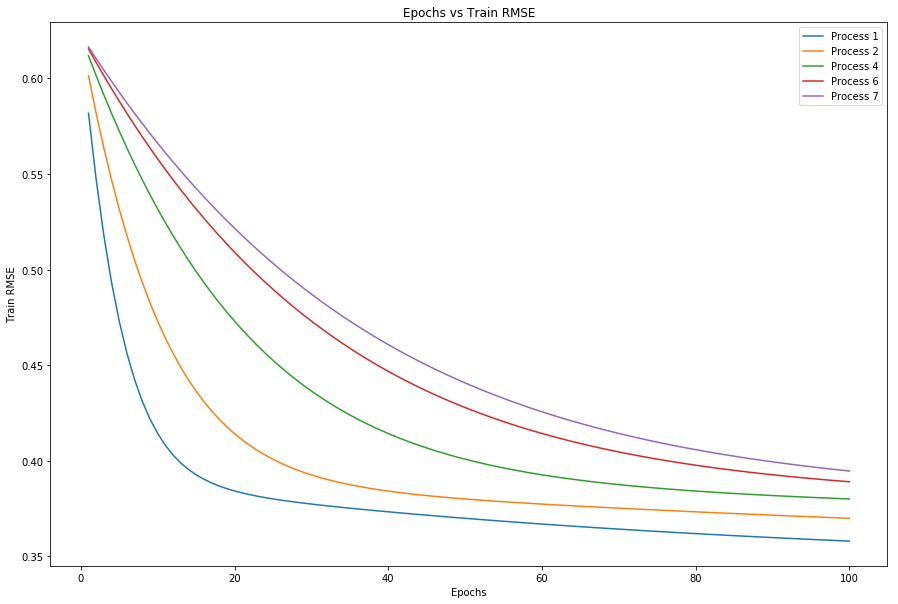

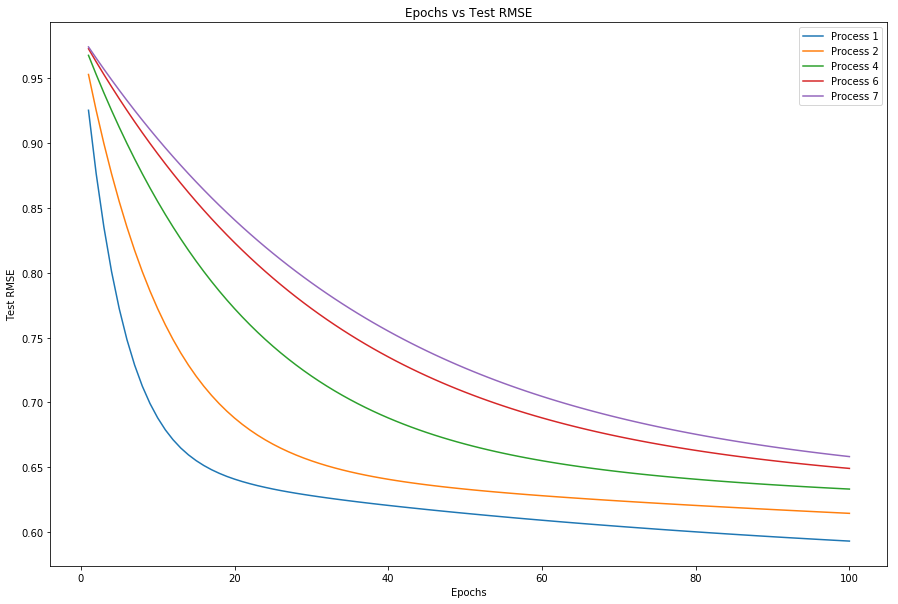

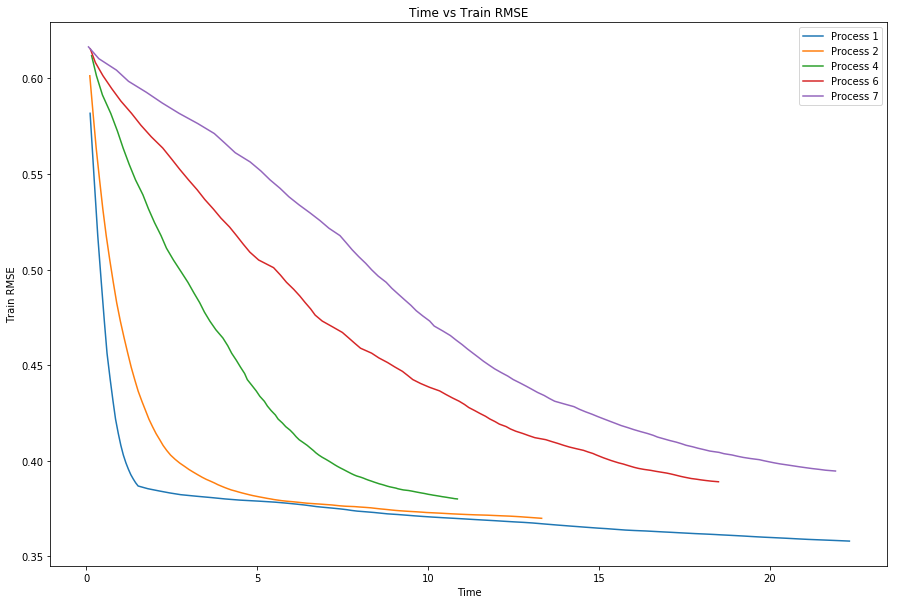

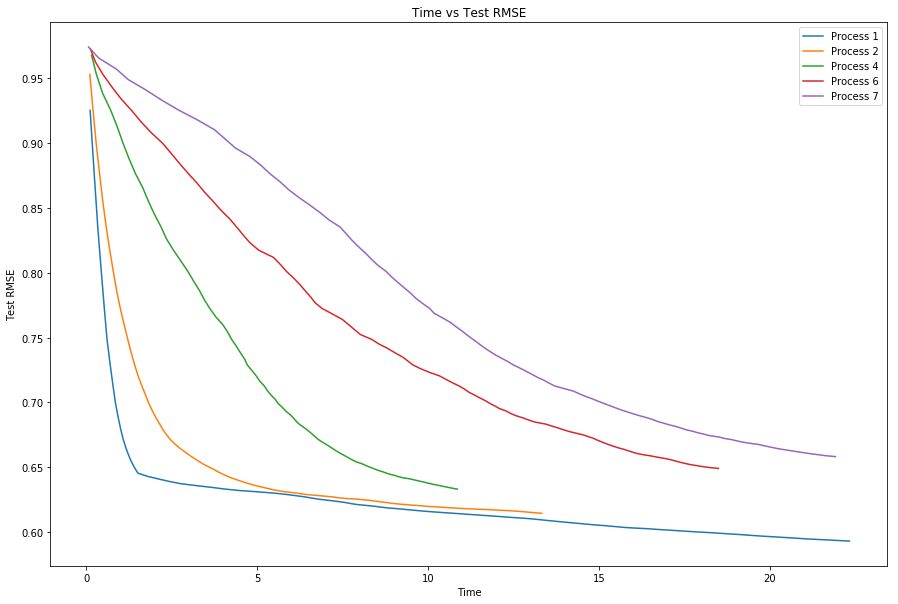

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

virus_process_train = pd.read_csv("Cup_Process_Train.csv")
epochs = [i for i in range(1,len(virus_process_train["Process 1"])+1)]
plt.figure(figsize=(15,10))
cols = virus_process_train.columns
odd = [i for i in range(len(cols)) if i%2 == 1]
for train in odd:
    plt.plot(epochs, virus_process_train[cols[train]],label=cols[train])
    plt.xlabel("Epochs")
    plt.ylabel("Train RMSE")
    plt.title("Epochs vs Train RMSE")
    plt.legend()
    
virus_process_test = pd.read_csv("Cup_Process_Test.csv")
cols = virus_process_test.columns
plt.figure(figsize=(15,10))
for train in odd:
    plt.plot(epochs, virus_process_test[cols[train]],label=cols[train])
    plt.xlabel("Epochs")
    plt.ylabel("Test RMSE")
    plt.title("Epochs vs Test RMSE")
    plt.legend()
    
cols_train= virus_process_train.columns
plt.figure(figsize=(15,10))
for train in odd:
    plt.plot(virus_process_train[cols[train-1]], virus_process_train[cols[train]],label=cols[train])
    plt.xlabel("Time")
    plt.ylabel("Train RMSE")
    plt.title("Time vs Train RMSE")
    plt.legend()
plt.show()
    
cols = virus_process_test.columns
plt.figure(figsize=(15,10))
for train in odd:
    plt.plot(virus_process_test[cols[train-1]], virus_process_test[cols[train]],label=cols[train])
    plt.xlabel("Time")
    plt.ylabel("Test RMSE")
    plt.title("Time vs Test RMSE",fontsize = 12)
    plt.legend()

## PSGD - Virus Share

In [ ]:
%%file PSGD.py
from sklearn.datasets import load_svmlight_file
import os
import numpy as np
import pandas as pd
import scipy
import math
import matplotlib.pyplot as plt
from mpi4py import MPI

#Initialize communicators
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

def read_virusshare(directory):
    data = np.array([])
    label = []
    a = 0
    for files in os.listdir(directory)[:1]:
        x,y = load_svmlight_file(directory+files)
        a+=x.shape[0]
        if x.shape[1] < 479:
            pad = np.zeros((x.shape[0],1))
            x = scipy.sparse.hstack((x,np.array(pad)))
        data = scipy.sparse.vstack((data,x))
        data = data.tocsr()
        label.extend(y)
    return data[1:,].tocsr(),label

def read_cup98(directory):
    data = pd.read_csv(directory,low_memory=False)
    return data

def RMSE(y_data,y_pred):
    return np.sqrt(np.sum(pow((y_data - y_pred),2)))/len(y_pred)

def loss(beta,data,Y_train):
    pred = linalg_prediction(beta,data)
    return np.sum(pow((Y_train - pred),2))
    
def linalg_prediction(beta,data):
    X = np.ones((data.shape[0],data.shape[1]+1))
    X[:,1:] = data
    return np.dot(beta,X.T)

def linreg_PSGD(alpha,beta,Y_train,X_train):
    
    X = np.ones((X_train.shape[0],X_train.shape[1]+1))
    X[:,1:] = X_train
    index = np.arange(0,len(X))
    np.random.shuffle(index)
    for i in index:
        xtr = X[i]
        ytr = Y_train[i]
        Y_prediction = np.dot(beta,xtr.T)
        residual = Y_prediction - ytr
        func_gradient = 2 * np.dot(xtr.T,residual)
        beta = beta - (alpha * func_gradient)
    return beta  

def create_Test_Train_data(X_data,Y_data):
    Y_train = Y_data[:math.ceil(0.7*len(Y_data))]
    Y_test = Y_data[math.ceil(0.7*len(Y_data)):]
    X_train = X_data[:math.ceil(0.7*len(X_data))]
    X_test = X_data[math.ceil(0.7*len(X_data)):]
    return Y_train,Y_test,X_train,X_test

flag = True
beta_split,beta_new = None,None
epoch = 1
rmse_train,rmse_test,time = [],[],[]

if rank == 0:
    beta_new,beta_split = None,None
    virus_directory = "G:/DA - Hildeshim/DDA Lab/Exercise 4/Virusshare/"
    virus_data, virus_label = read_virusshare(virus_directory)
    X_data = pd.DataFrame(virus_data[:1000].todense())
    Y_data = virus_label[:1000]
    Y_train,Y_test,X_train,X_test = create_Test_Train_data(X_data,Y_data)
    X_train_split = np.array_split(X_train,size-1)
    Y_train_split = np.array_split(Y_train,size-1)
    beta = np.zeros((X_data.shape[1]+1))
    for worker in range(1,size):
        comm.send(X_train_split[worker-1],dest = worker,tag = 1)
        comm.send(Y_train_split[worker-1],dest = worker,tag = 2)

else:
    beta = None
    X_test = None
    Y_test = None
    X_train = comm.recv(source = 0,tag = 1)
    Y_train = comm.recv(source = 0,tag = 2)

start = MPI.Wtime()
for i in range(100): #epochs
    beta = comm.bcast(beta,root = 0)
    X_test = comm.bcast(X_test,root = 0)
    Y_test = comm.bcast(Y_test,root = 0)
    if rank != 0:
        beta_split = linreg_PSGD(1.08e-10,beta,Y_train,X_train)

    comm.Barrier()
    beta_new = comm.gather(beta_split,0)
    comm.Barrier()
    if rank == 0:

        losstrain_old = loss(beta,X_train,Y_train)
        beta = np.sum(np.array(beta_new)[1:,])/(size-1)
        losstrain_new= loss(beta,X_train,Y_train)
        if abs(losstrain_old - losstrain_new) < 1e-20:
            print("Converged")
            break
        y_pred_train = linalg_prediction(beta,X_train)
        rmse_train.append(RMSE(Y_train,y_pred_train))
        y_pred_test = linalg_prediction(beta,X_test)
        rmse_test.append(RMSE(Y_test,y_pred_test))
        time.append(MPI.Wtime() - start)
end = MPI.Wtime()
print("Rank: ",rank,"Time: ",end - start)
if rank == 0:
    df = pd.DataFrame({'TrainRMSE':rmse_train,'TestRMSE': rmse_test,'Time': time})
    df.to_csv('Virus_Process7.csv')

In [ ]:
!mpiexec -n 5 python PSGD.py

In [ ]:
!mpiexec -n 7 python PSGD.py

In [ ]:
!mpiexec -n 9 python PSGD.py

In [ ]:
!mpiexec -n 3 python PSGD.py

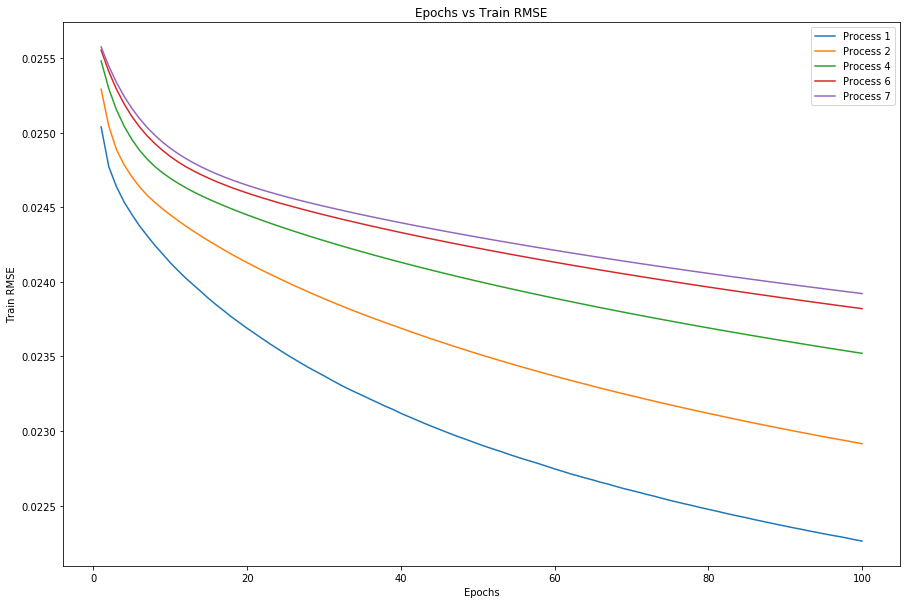

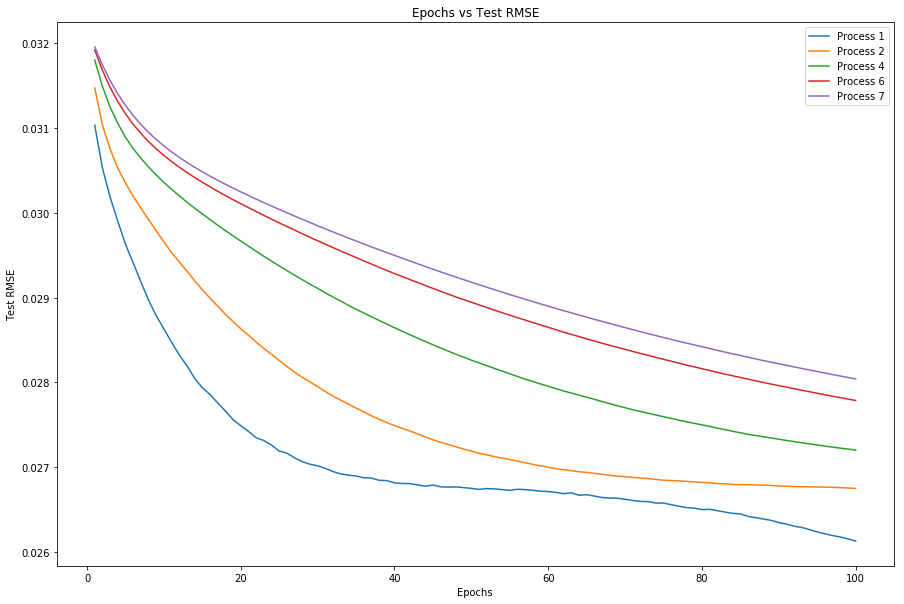

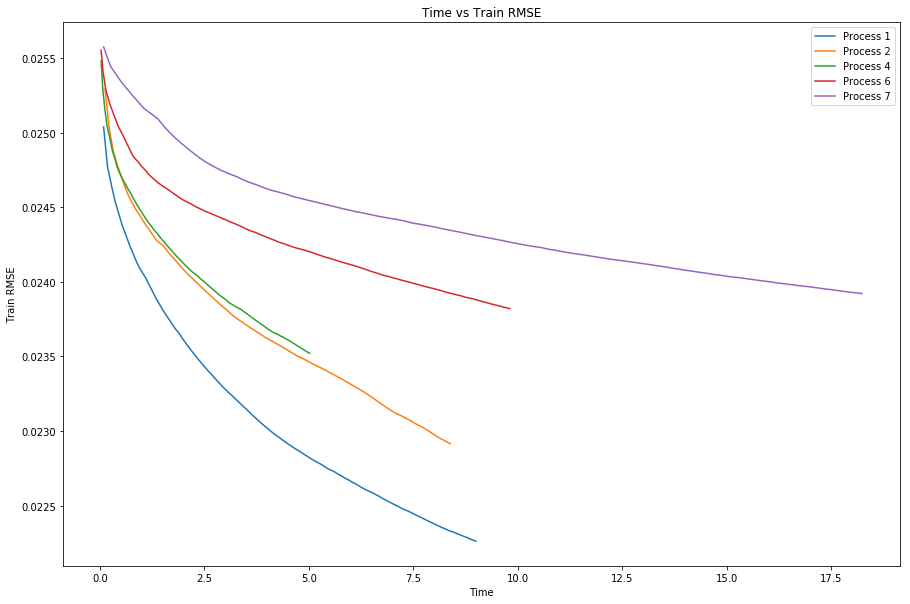

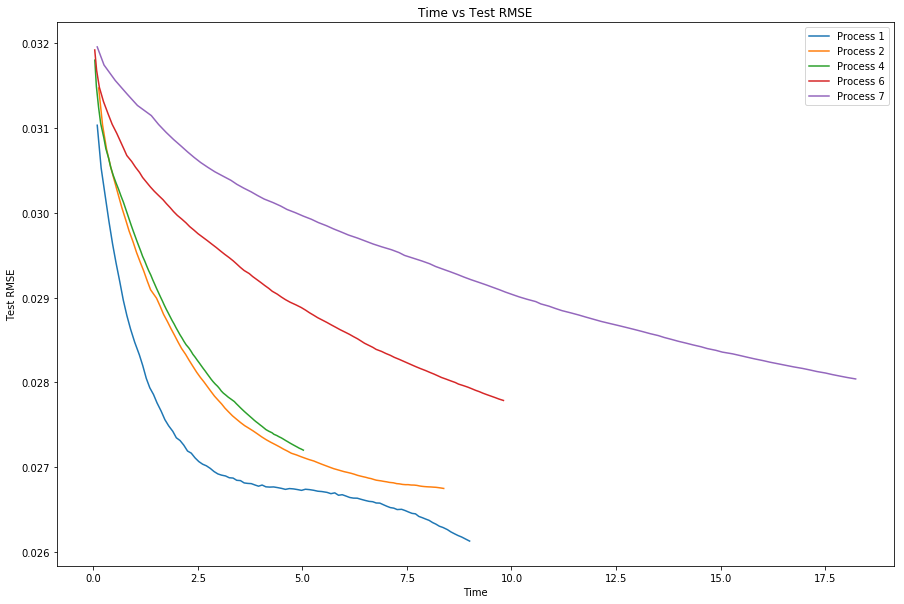

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

virus_process_train = pd.read_csv("Virus_Process_Train.csv")
epochs = [i for i in range(1,len(virus_process_train["Process 1"])+1)]
plt.figure(figsize=(15,10))
cols = virus_process_train.columns
odd = [i for i in range(len(cols)) if i%2 == 1]
for train in odd:
    plt.plot(epochs, virus_process_train[cols[train]],label=cols[train])
    plt.xlabel("Epochs")
    plt.ylabel("Train RMSE")
    plt.title("Epochs vs Train RMSE")
    plt.legend()
    
virus_process_test = pd.read_csv("Virus_Process_test.csv")
cols = virus_process_test.columns
plt.figure(figsize=(15,10))
for train in odd:
    plt.plot(epochs, virus_process_test[cols[train]],label=cols[train])
    plt.xlabel("Epochs")
    plt.ylabel("Test RMSE")
    plt.title("Epochs vs Test RMSE")
    plt.legend()
    
cols_train= virus_process_train.columns
plt.figure(figsize=(15,10))
for train in odd:
    plt.plot(virus_process_train[cols[train-1]], virus_process_train[cols[train]],label=cols[train])
    plt.xlabel("Time")
    plt.ylabel("Train RMSE")
    plt.title("Time vs Train RMSE")
    plt.legend()
plt.show()
    
cols = virus_process_test.columns
plt.figure(figsize=(15,10))
for train in odd:
    plt.plot(virus_process_test[cols[train-1]], virus_process_test[cols[train]],label=cols[train])
    plt.xlabel("Time")
    plt.ylabel("Test RMSE")
    plt.title("Time vs Test RMSE",fontsize = 12)
    plt.legend()
